In [1]:
import pandas as pd
import numpy as np
import sklearn
import zipfile
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
import warnings
from pandas.core.common import SettingWithCopyWarning
from sklearn.feature_selection import chi2, SelectKBest, f_regression
from scipy.cluster import hierarchy 
from category_encoders import TargetEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_transformer
from sklearn.linear_model import Lasso

In [2]:
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [3]:
# Unzip file
with zipfile.ZipFile('craigslist-carstrucks-data.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

Steps:
- Identify relevant features for the prediction task
- Features leak target information?
- Show visualizations or statistics to support your selection
- Not required to use the description column, but can try to come up with relevatn features from it

## Task 1

In [3]:
df = pd.read_csv('data/vehicles.csv')

Drop all rows which have 0 price. For the scope of this regression problem, having 0 does not mean that the car is free but that the user decided to not list a price, possibly to prevent potential buyers from being intimidated by a large number. Thus, for such cases, 0 price is not representative of the car's actual value

In [4]:
df = df[df['price']!= 0]

Subsample the data

In [5]:
sample_frac = 0.50
df = df.sample(frac=sample_frac, random_state=0)

In [6]:
# Take the price column out
# Also drop the description column as it includes the price which may be leaking the target
price = df.price
X = df.drop(columns='price')

Drop repetitive data such as the region_url, which contains the same information as 'region'.
Also drop 'url' which contains the same information as 'region', 'make', and 'model'.
Drop 'image_url' as all are images.craiglist. Drop 'vin' as it is are unique for every single data sample and therefore, not important for predicting price. Also drop description as this may include the price, thereby leaking the target, while providing uncessary information. Drop 'county' as the entire column in NaN and therefore, adds 0 value in predicting the price.

In [7]:
columns_to_drop = ['url', 'region_url', 'description', 'county']
X = X.drop(columns=columns_to_drop)

Get the relative datatypes of the different columns (i.e. if it is object vs float).
Also figure out which columns contain NaN values which need to be imputed

In [8]:
data_obj = [col for col in X.columns if X[col].dtype == 'object']
data_float = [col for col in X.columns if X[col].dtype != 'object']
cols_nan = X.columns[X.isna().any()].tolist()
data_obj_missing = [col for col in data_obj if col in cols_nan]
data_float_missing = [col for col in data_float if col in cols_nan]

In [9]:
impute_categorical = SimpleImputer(strategy='most_frequent', missing_values=np.nan)
impute_float = SimpleImputer(strategy='median',missing_values=np.nan)

In [ ]:
X[data_obj_missing] = impute_categorical.fit_transform(X[data_obj_missing])

In [ ]:
X[data_float_missing] = impute_float.fit_transform(X[data_float_missing])

## Numerical Data: High level feature analysis

Plot continuous data to get an idea of feature importance

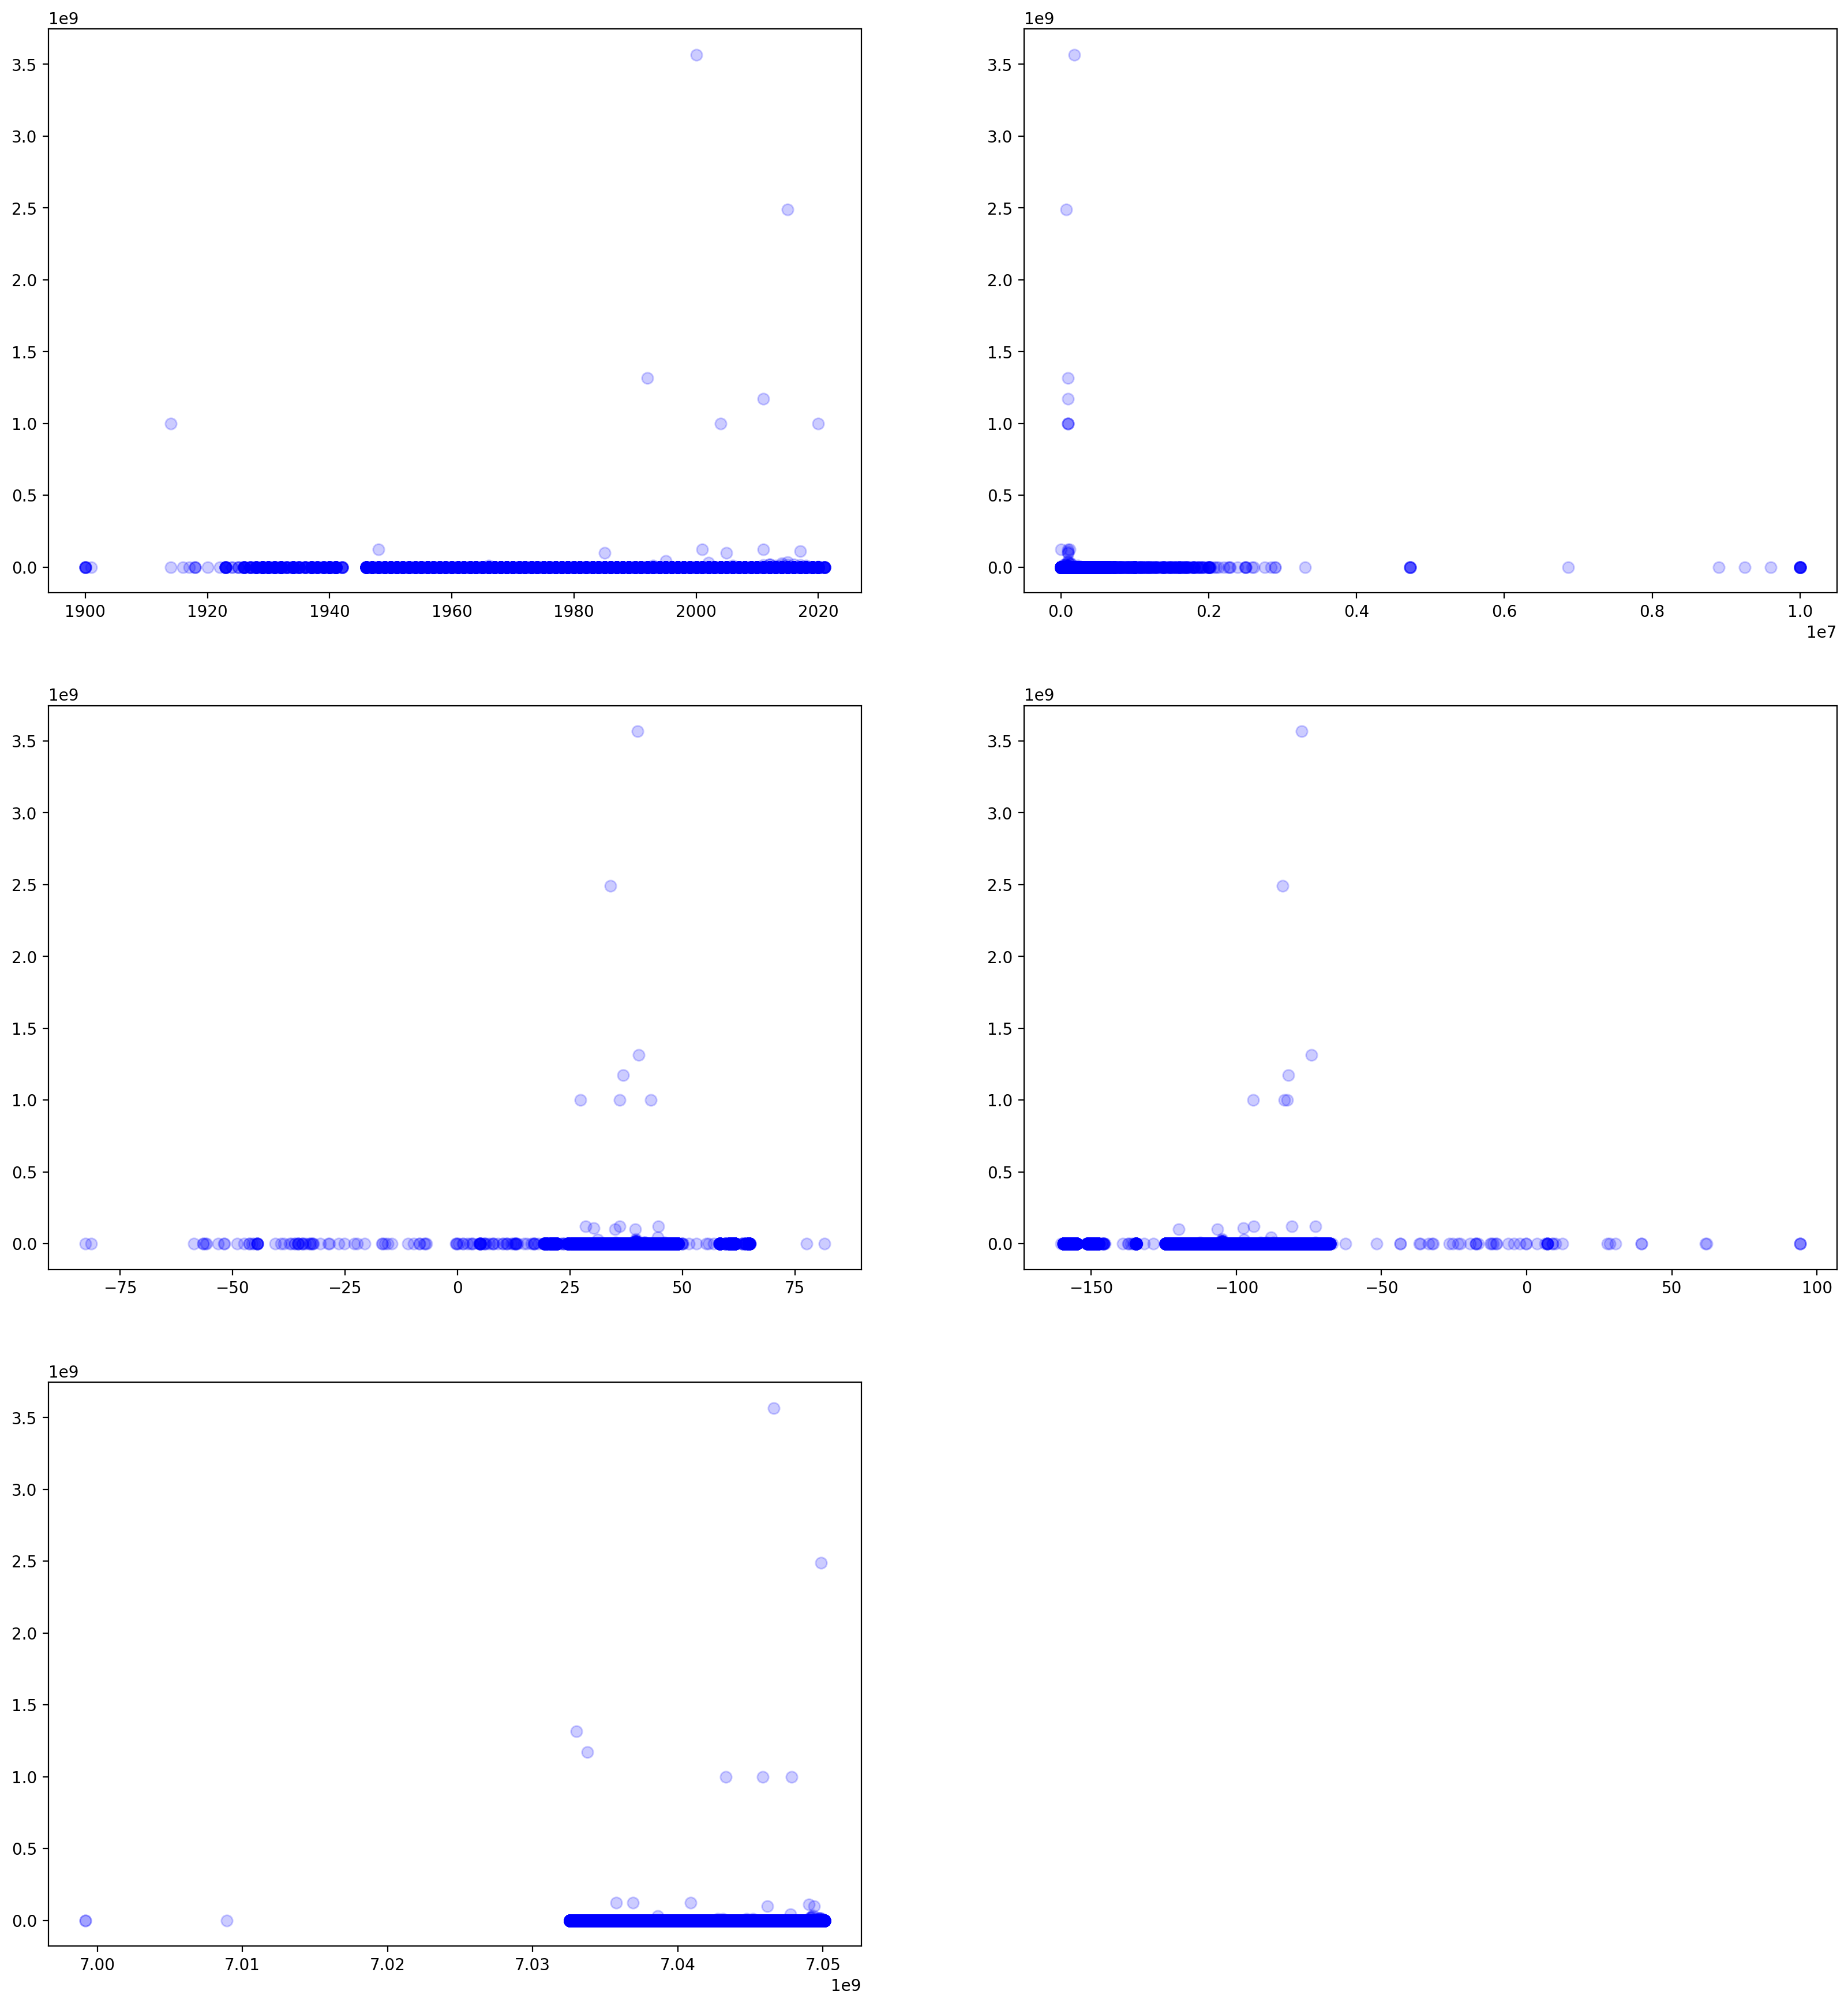

In [30]:
fig, ax = plt.subplots(3, 2, figsize=(20,22), dpi=200)
ax1, ax2, ax3, ax4, ax5, ax6 = ax.ravel()

ax1.plot(X['year'], price, 'bo', alpha=0.2, markersize=7)
ax2.plot(X['odometer'], price, 'bo', alpha=0.2, markersize=7)
ax3.plot(X['lat'], price, 'bo', alpha=0.2, markersize=7)
ax4.plot(X['long'], price, 'bo', alpha=0.2, markersize=7)
ax5.plot(X['id'], price, 'bo', alpha=0.2, markersize=7)
ax6.remove()
plt.show()

Adjust y-lims to see data further zoomed in

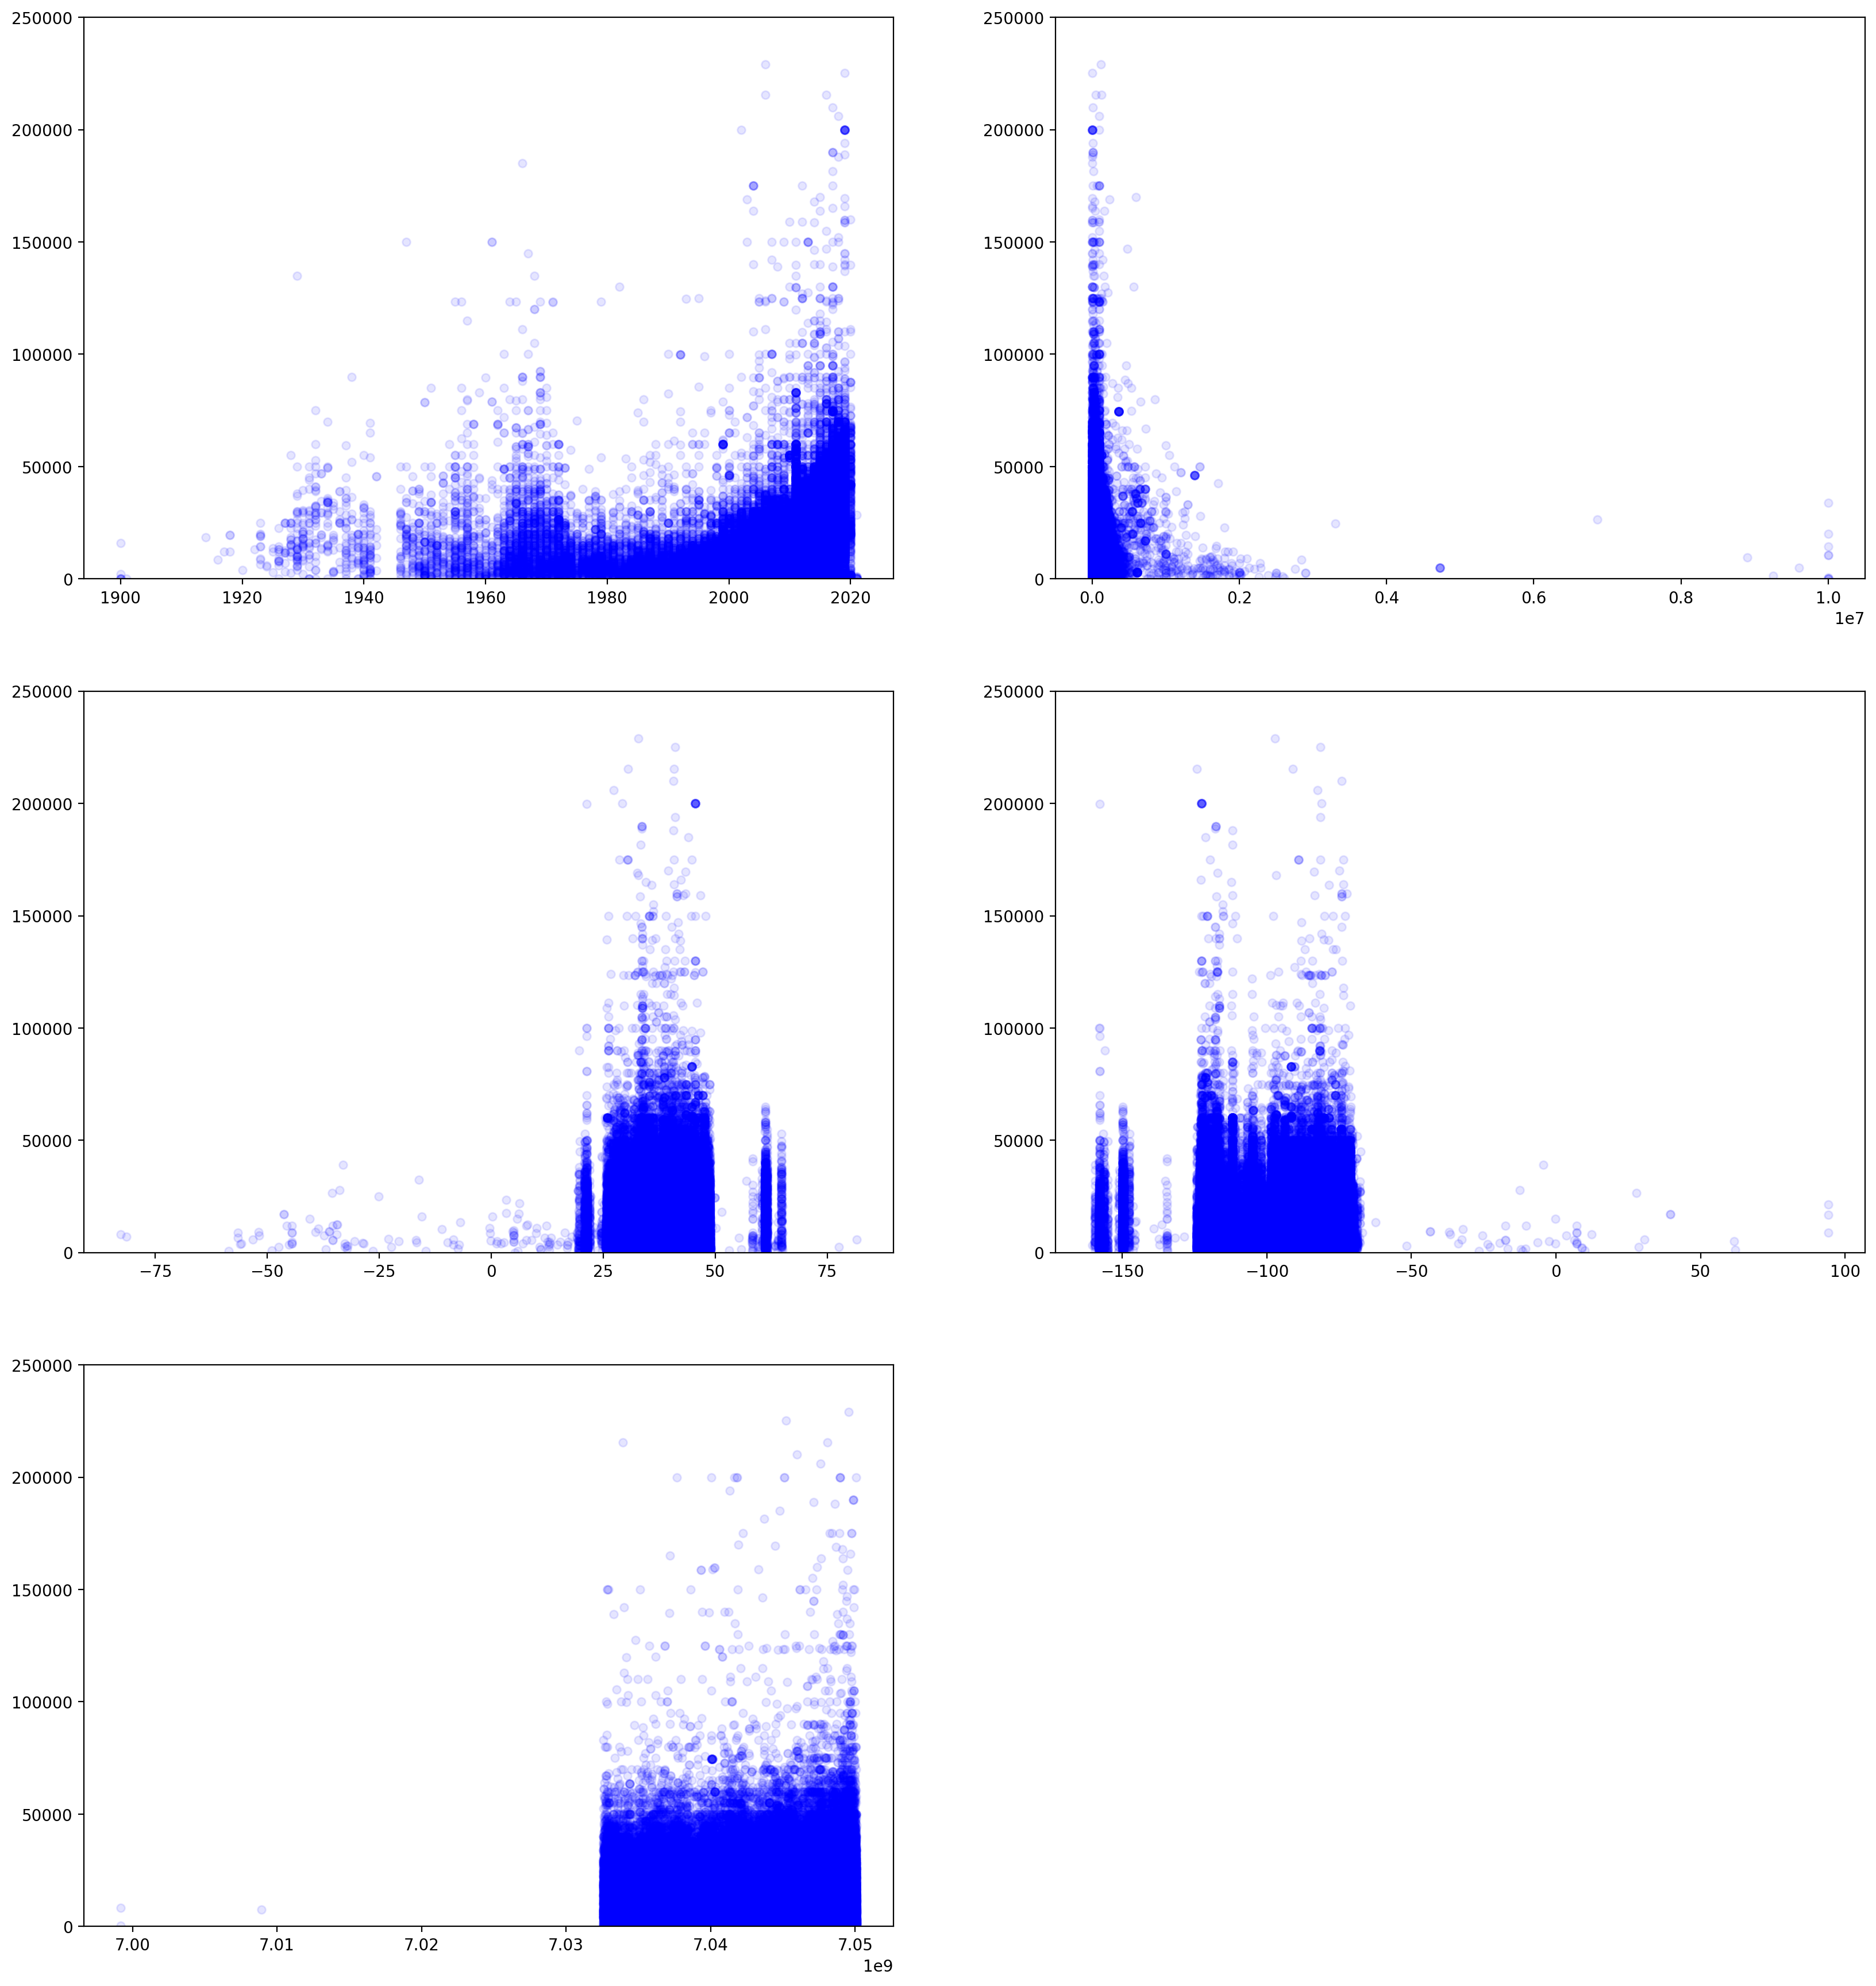

In [31]:
fig, ax = plt.subplots(3, 2, figsize=(20,22), dpi=200)
ax1, ax2, ax3, ax4, ax5, ax6 = ax.ravel()

ax1.plot(X['year'], price, 'bo', alpha=0.1, markersize=5)
ax1.set_ylim(-10, 0.00025E9)

ax2.plot(X['odometer'], price, 'bo', alpha=0.1, markersize=5)
ax2.set_ylim(-10, 0.00025E9)

ax3.plot(X['lat'], price, 'bo', alpha=0.1, markersize=5)
ax3.set_ylim(-10, 0.00025E9)

ax4.plot(X['long'], price, 'bo', alpha=0.1, markersize=5)
ax4.set_ylim(-10, 0.00025E9)

ax5.plot(X['id'], price, 'bo', alpha=0.1, markersize=5)
ax5.set_ylim(-10, 0.00025E9)

ax6.remove()
plt.show()

One can calculate the correlation between each of the numeric features and the price to quantify their possible relation

In [32]:
for col in data_float:
    print(f'Feature:  {col}')
    print(f'Correlation with price: {X[col].corr(price)}')

Feature:  id
Correlation with price: -3.653335424895206e-05
Feature:  year
Correlation with price: -0.006314962677871322
Feature:  odometer
Correlation with price: 0.0003151473710351921
Feature:  lat
Correlation with price: -0.0010265531671245498
Feature:  long
Correlation with price: 0.0032492997282430472


Calculate covariance values

In [33]:
cov = abs(X[data_float].corr().to_numpy())
order = np.array(hierarchy.dendrogram(hierarchy.ward(cov),no_plot=True)['ivl'], dtype=int)
sorted_keys = [data_float[x] for x in order]

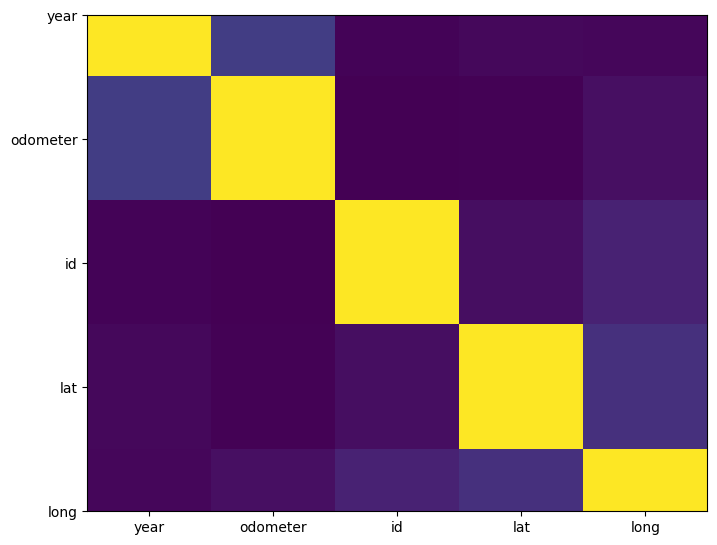

In [34]:
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(cov[order, :][:, order])
plt.xticks(range(len(sorted_keys)), sorted_keys)
plt.yticks(range(len(sorted_keys)), sorted_keys)
plt.show()

Based on the above results, drop id based on graph and also correlation. Could also potentially drop odometer because doesnt show a strong coorelation to price and is correlated to the year. Potentially drop latitude and longitude as they display a fairly uniform distribution when plotted vs price.

## Categorical Data: High Level Feature Analysis

In [104]:
# Ordinal Encoding, maybe target encode?
ordinal_encoder = preprocessing.OrdinalEncoder()
ordinal_encoder.fit(X[data_obj])
X_ordinal = ordinal_encoder.transform(X[data_obj])

In [105]:
fs = SelectKBest(score_func=f_regression, k='all')
fs.fit(X_ordinal, price)
scores = fs.scores_

In [106]:
score_feature_pairs = list(zip(fs.scores_, data_obj, fs.pvalues_))
sorted_list = sorted(score_feature_pairs)
for item in sorted_list:
    print(f'Category: {item[1]}, {item[0]}, {item[2]}')

Category: image_url, 0.023792132118115317, 0.8774151310399585
Category: fuel, 0.024688683912299305, 0.8751454222723614
Category: type, 0.23508876239650764, 0.6277764484006509
Category: title_status, 0.2770293470153411, 0.5986554323328023
Category: paint_color, 0.360140333801946, 0.5484288916668101
Category: manufacturer, 0.45664011352761524, 0.49919909178054733
Category: state, 0.4981532526551262, 0.4803133983991472
Category: drive, 0.9933493546497669, 0.31892617354872554
Category: model, 0.9999061570360465, 0.3173342546336977
Category: condition, 1.0984123486099395, 0.2946158787252619
Category: cylinders, 1.8076604336082742, 0.17879044678759634
Category: region, 2.0490475477493253, 0.15230278402303674
Category: size, 3.6964562790982476, 0.0545293801510592
Category: vin, 3.861893796863559, 0.04939573140856954
Category: transmission, 11.329062704149482, 0.0007631572212845547


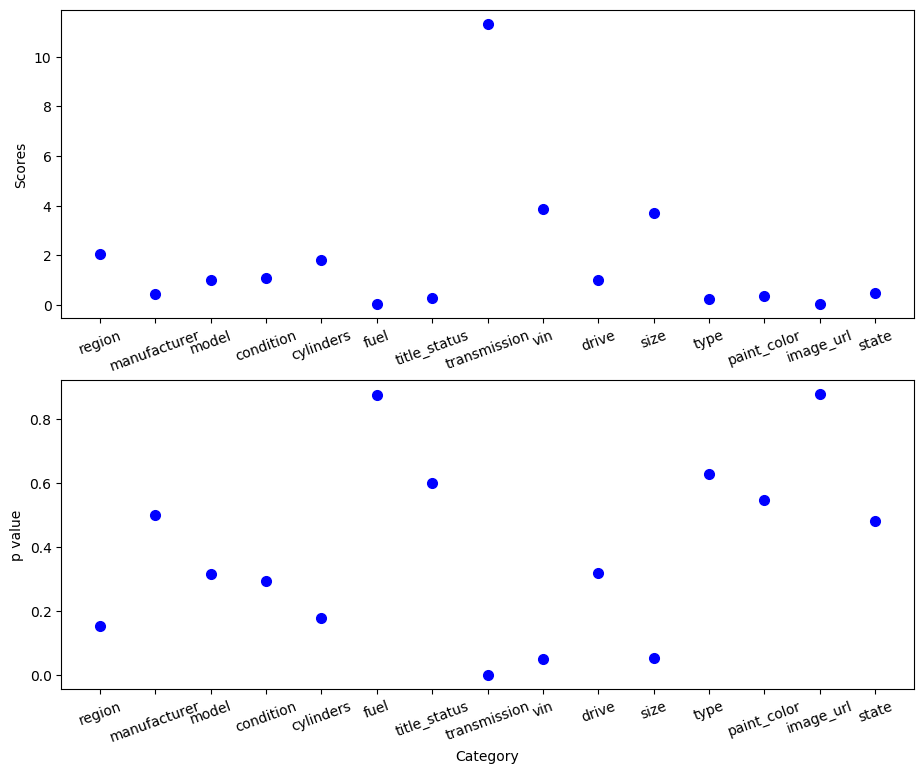

In [129]:
fig, ax = plt.subplots(2, 1, figsize=(11,9), dpi=100)
ax1, ax2 = ax.ravel()
ax1.plot(fs.scores_, 'bo', markersize=7)
ax1.set_xticks(range(len(data_obj)))
ax1.set_xticklabels(labels=data_obj, rotation=20)
ax1.set_ylabel('Scores')
ax1.set_xlabel('Category')

ax2.plot(fs.pvalues_, 'bo', markersize=7)
ax2.set_xticks(range(len(data_obj)))
ax2.set_xticklabels(labels=data_obj, rotation=20)
ax2.set_ylabel('p value')
ax2.set_xlabel('Category')
plt.show()

- Null Hypothesis: All the regression coefficients are 0
- If sig value < p value, then can conlude the value is important
- Very low F scores to indicate lower cross-correlation

Based on the f_regression test using the categorical variables, it can be seen that transmission has a high score with a very small p value (lower than the significance level of 0.01), and therefore, it is an important feature to keep going forward. While vin and size also produce large values with small p-values, these rows consist of significantly imputed results (67% for size and 41% for vin), therefore, these numbers may not be well representative of significance. Vin, more specifically, is an identification number and therefore, should not impact price. It was therefore be dropped in the next steps. On the other end of the spectrum, image_url produced the lowest f_score with the highest p-value, indicating that this feature can be dropped going forward. 

## Task 2

In [130]:
rows_to_drop = ['odometer', 'id', 'vin', 'image_url']
more_rows = ['long', 'lat', 'title_status', 'fuel', 'type']

In [131]:
X = X.drop(columns=rows_to_drop)

In [132]:
X

,region,year,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,state,lat,long
487623,dallas / fort worth,2012.0,ford,freightliner cascadia,excellent,8 cylinders,diesel,clean,manual,4wd,full-size,truck,orange,tx,26.3446,-80.2109
390893,akron / canton,2003.0,ram,1500,excellent,8 cylinders,gas,clean,automatic,4wd,full-size,pickup,grey,oh,41.1790,-81.2464
24431,olympic peninsula,2017.0,ram,1500,excellent,8 cylinders,gas,clean,automatic,4wd,full-size,truck,white,wa,47.1991,-122.3150
345946,lincoln,2017.0,toyota,tundra 4wd 4x4 sr5 4dr cr,excellent,6 cylinders,gas,clean,automatic,4wd,full-size,sedan,white,ne,41.1303,-96.2532
363858,albany,1966.0,ford,Plymouth Barracuda,excellent,6 cylinders,gas,clean,manual,rwd,full-size,sedan,blue,ny,42.1974,-73.5097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234355,dubuque,2011.0,gmc,yukon xl denali,excellent,8 cylinders,gas,clean,automatic,4wd,full-size,SUV,black,ia,41.8296,-90.2021
2707,vermont,2015.0,chevrolet,express,good,8 cylinders,gas,clean,automatic,rwd,full-size,truck,white,vt,40.4688,-74.2817
389751,north dakota,2007.0,ram,f-150,excellent,6 cylinders,diesel,clean,automatic,fwd,full-size,pickup,red,nd,40.3744,-104.6940
222006,"st louis, MO",2012.0,chevrolet,traverse,excellent,6 cylinders,gas,clean,automatic,fwd,full-size,SUV,silver,il,38.6091,-90.5598


In [259]:
X_train, X_test, y_train, y_test = train_test_split(X, price, shuffle=True, random_state=0)
cv_strategy = KFold(n_splits=10, shuffle=True, random_state=0)

In [260]:
data_obj_refined = [x for x in data_obj if x not in rows_to_drop]
data_float_refined = [x for x in data_float if x not in rows_to_drop]

Simple pre-processing and encoding on the selected features

In [261]:
target_encode = ['model', 'region']
data_float_refined.extend(target_encode)
data_obj_refined = [x for x in data_obj_refined if x not in target_encode]

In [182]:
target_encoding = Pipeline([('encode', TargetEncoder())])
cat_encoding = Pipeline([('encode', preprocessing.OneHotEncoder(handle_unknown='ignore'))])  
cont_encoding = Pipeline([('scale', preprocessing.StandardScaler())])
processing_pipe = make_column_transformer((cont_encoding, data_float_refined),
                                        (cat_encoding, data_obj_refined), 
                                        remainder='passthrough')

In [262]:
te = TargetEncoder()
X_train_te = te.fit_transform(X_train[target_encode], y_train)
X_train[target_encode] = X_train_te
X_train

,region,year,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,state,lat,long
369633,7800.983871,2013.0,honda,7132.556391,excellent,4 cylinders,gas,clean,automatic,4wd,full-size,SUV,blue,ny,42.0970,-79.2360
115867,14559.666667,1997.0,lexus,3215.428571,excellent,6 cylinders,gas,clean,automatic,fwd,full-size,sedan,white,ca,35.1222,-120.6260
380124,11145.625000,1950.0,jeep,20554.526142,excellent,6 cylinders,gas,clean,manual,4wd,full-size,sedan,white,ny,43.0489,-76.5425
411684,16165.068437,2015.0,ford,20821.000000,excellent,6 cylinders,gas,clean,automatic,rwd,full-size,sedan,white,ok,35.3900,-97.4131
393632,10777.758209,2016.0,toyota,14120.250000,excellent,6 cylinders,gas,clean,automatic,4wd,full-size,sedan,red,oh,39.1871,-84.6533
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19176,18136.762244,2017.0,ram,31482.580090,excellent,8 cylinders,gas,clean,automatic,4wd,full-size,truck,custom,wa,47.1991,-122.3150
341816,11261.843687,2004.0,toyota,13485.108163,good,6 cylinders,gas,clean,automatic,4wd,mid-size,SUV,white,nc,36.0788,-81.1781
205451,20712.226027,2015.0,ford,25292.859649,excellent,6 cylinders,gas,clean,automatic,4wd,full-size,truck,grey,id,47.6561,-117.2370
508572,17535.718750,2004.0,ford,33222.969288,good,10 cylinders,gas,clean,automatic,4wd,full-size,truck,white,ut,40.3179,-111.7040


In [263]:
ss = preprocessing.StandardScaler()
X_train[data_float_refined] = ss.fit_transform(X_train[data_float_refined])

In [264]:
X_train

,region,year,manufacturer,model,condition,cylinders,fuel,title_status,transmission,drive,size,type,paint_color,state,lat,long
369633,-0.046486,0.420430,honda,-0.028800,excellent,4 cylinders,gas,clean,automatic,4wd,full-size,SUV,blue,ny,0.613924,0.842912
115867,-0.041578,-1.420853,lexus,-0.030621,excellent,6 cylinders,gas,clean,automatic,fwd,full-size,sedan,white,ca,-0.562947,-1.511431
380124,-0.044057,-6.829622,jeep,-0.022562,excellent,6 cylinders,gas,clean,manual,4wd,full-size,sedan,white,ny,0.774540,0.996123
411684,-0.040412,0.650590,ford,-0.022438,excellent,6 cylinders,gas,clean,automatic,rwd,full-size,sedan,white,ok,-0.517761,-0.191036
393632,-0.044324,0.765671,toyota,-0.025553,excellent,6 cylinders,gas,clean,automatic,4wd,full-size,sedan,red,oh,0.122931,0.534766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19176,-0.038980,0.880751,ram,-0.017483,excellent,8 cylinders,gas,clean,automatic,4wd,full-size,truck,custom,wa,1.474812,-1.607504
341816,-0.043972,-0.615292,toyota,-0.025848,good,6 cylinders,gas,clean,automatic,4wd,mid-size,SUV,white,nc,-0.401538,0.732442
205451,-0.037110,0.650590,ford,-0.020360,excellent,6 cylinders,gas,clean,automatic,4wd,full-size,truck,grey,id,1.551922,-1.318658
508572,-0.039417,-0.615292,ford,-0.016674,good,10 cylinders,gas,clean,automatic,4wd,full-size,truck,white,ut,0.313733,-1.003930


In [265]:
processing_pipe = make_column_transformer((cat_encoding, data_obj_refined), 
                                        remainder='passthrough')

In [ ]:
lasso_pipe = make_pipeline(processing_pipe, Lasso(max_iter=5000))
param_grid = {'lasso__alpha': np.logspace(-3,3,7)}
lasso_grid = GridSearchCV(lasso_pipe, param_grid, cv=cv_strategy, n_jobs=-1, return_train_score=True)
lasso_grid.fit(X_train, y_train)
lasso_grid.best_score_